In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif

In [2]:
df = pd.read_csv('train_raw.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_18472\2013681907.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('train_raw.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

In [4]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Columns with missing values:")
print(missing_values)

Columns with missing values:
Name                        9985
Monthly_Inhand_Salary      15002
Type_of_Loan               11408
Num_of_Delayed_Payment      7002
Num_Credit_Inquiries        1965
Credit_History_Age          9030
Amount_invested_monthly     4479
Monthly_Balance             1200
dtype: int64


In [ ]:
extra_columns_to_remove = ['ID', 'Customer_ID', 'Name', 'SSN', 'Type_of_Loan']
df = df.drop(columns=extra_columns_to_remove, errors='ignore')

In [6]:
num_cols = [
    "Age", "Annual_Income", "Monthly_Inhand_Salary", "Num_Bank_Accounts", "Num_Credit_Card",
    "Interest_Rate", "Num_of_Loan", "Delay_from_due_date", "Num_of_Delayed_Payment",
    "Changed_Credit_Limit", "Num_Credit_Inquiries", "Outstanding_Debt",
    "Credit_Utilization_Ratio", "Total_EMI_per_month", "Amount_invested_monthly",
    "Monthly_Balance", "Credit_History_Age"
]



def clean_numeric_columns(df, num_cols):
    for col in num_cols:
        df[col] = df[col].astype(str).str.replace(r"[^\d.]", "", regex=True)  
        df[col] = pd.to_numeric(df[col], errors='coerce') 
    return df

# Clean numerical columns
df = clean_numeric_columns(df, num_cols)

In [7]:
# Impute
knn_imputer = KNNImputer(n_neighbors=5)

df[num_cols] = knn_imputer.fit_transform(df[num_cols])

In [8]:
print(df.isnull().sum())

Month                       0
Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Credit_Score                0
dtype: int64


Selected features: ['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt', 'Payment_of_Min_Amount', 'Total_EMI_per_month']


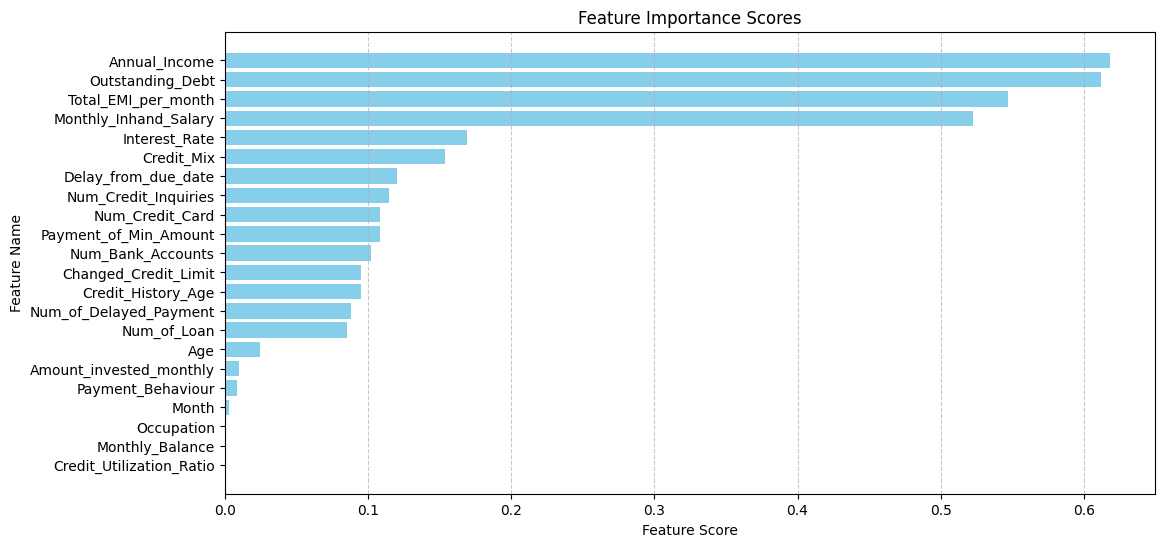

In [17]:
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))


X = df_encoded.drop(columns=['Credit_Score'])
y = df_encoded['Credit_Score']

# Apply SelectKBest
select_k_best = SelectKBest(score_func=mutual_info_classif, k=12)
X_train_k_best = select_k_best.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[select_k_best.get_support()]

# Print selected features
print("Selected features:", selected_features.tolist())

# Create DataFrame for feature scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': select_k_best.scores_})
feature_scores = feature_scores.sort_values(by="Score", ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_scores['Feature'], feature_scores['Score'], color='skyblue')
plt.xlabel("Feature Score")
plt.ylabel("Feature Name")
plt.title("Feature Importance Scores")
plt.grid(axis='x', linestyle="--", alpha=0.7)
plt.show()



In [18]:
le = LabelEncoder()
le.fit(df['Credit_Score']) 
print("\nLabel Encoding Mapping:")
for idx, class_name in enumerate(le.classes_):
    print(f"{class_name} → {idx}")

selected_features = X.columns[select_k_best.get_support()]
X_train_selected = pd.DataFrame(X_train_k_best, columns=selected_features, index=X.index)
X_train_selected['Credit_Score'] = y

# Split 10% of the selected training data as unseen data
selected_train, selected_unseen = train_test_split(X_train_selected, test_size=0.1, random_state=42)


selected_train.to_csv("cleaned_train.csv", index=False)
selected_unseen.to_csv("cleaned_unseen.csv", index=False)


Label Encoding Mapping:
Good → 0
Poor → 1
Standard → 2
